In [1]:
import os
from dotenv import load_dotenv
from langchain_aws import ChatBedrock
from botocore.config import Config
import boto3
from langchain_openai import ChatOpenAI

load_dotenv()

def llm_llama():
    
    config = Config(read_timeout=120)
    AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
    AWS_ACCESS_KEY= os.getenv("AWS_ACCESS_KEY_ID")

    client = boto3.client('bedrock-runtime', region_name='us-west-2',config=config, aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_ACCESS_KEY,)
 
    llm = ChatBedrock(
        client=client,
        model_id="arn:aws:bedrock:us-west-2:585008056358:inference-profile/us.meta.llama3-3-70b-instruct-v1:0",
        provider="meta",
        model_kwargs={"temperature": 0},
        region="us-west-2"
    )

    return llm

def llm_4o():
    llm  = ChatOpenAI(model="gpt-4o-2024-11-20", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))
    return llm

def llm_o1_mini():
    llm = ChatOpenAI(model="o1-mini", api_key=os.getenv("OPENAI_API_KEY"))
    return llm

In [2]:
from twelvedata import TDClient
from datetime import datetime, timedelta
import pandas as pd

def get_data(interval, num_candles, date=datetime.now()):
    TWELVE_DATA_API= os.getenv("TWELVE_DATA_API")

    # Format the current time to the required format
    formatted_time = date.strftime("%Y-%m-%d %H:%M:%S")
    td = TDClient(apikey=TWELVE_DATA_API)

    ts = td.time_series(
        symbol="EUR/USD",
        interval=interval,
        outputsize=num_candles,
        timezone="America/New_York",
        order="asc",
        end_date = formatted_time
    )

    return ts.as_pandas()


In [3]:
from langchain_core.prompts import ChatPromptTemplate

def htf_agent_operation(htf_df):
    # HTF agent for identifying the trend bias
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """
    You are a specialized Forex Market Analyst focusing on higher-timeframe trends using Smart Money Concepts.
    Your job is to:
    1. Determine the overall trend (bullish, bearish, ranging) rate 1-10 how strong the trend is.
    2. Identify major swing points (highs/lows).
    3. Summarize any significant daily order blocks or liquidity zones that are clearly visible (including swing high or low).

    Format your response as:
    - Overall HTF Bias: [bullish/bearish/ranging]
    - Key Swing Highs and Lows: ...
    - Any Notable Liquidity or Order Blocks: ...
    - Brief Explanation (1–2 sentences).

    Important:
    - Do not invent data. If uncertain, say “Not enough info.”
    - Be concise and to the point in your analysis.
    """),
            ("user", "Daily Data"),
            ("user", "{htf_df}"),
            ("user", "Please analyze this data to determine the 4h (HTF) directional bias, major swing points, and any relevant daily order blocks or liquidity pools.")
        ]
    )

    htf_agent_chain = prompt | llm_llama()

    htf_info = htf_agent_chain.invoke({"htf_df": htf_df.to_string()})

    htf_info_structured = htf_info.content

    return htf_info_structured

In [4]:
from langchain_core.prompts import ChatPromptTemplate

def mtf_agent_operation(mtf_df):

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """
You are an advanced Forex Analyst specializing in Smart Money Concepts on the 1-hour timeframe. Your tasks:

Determine the current trend bias (bullish, bearish, ranging)

Identify 1H Order Blocks
Bullish OB: Typically the last down candle (or small cluster) before an impulsive up move that breaks structure.
Bearish OB: Typically the last up candle (or cluster) before an impulsive down move that breaks structure.
Only consider high-probability OBs where there is clear displacement (strong momentum) away from the zone and a structure shift.
             
Mark Key Liquidity Pools
Above relative equal highs (potential “buy stops” for liquidity).
Below relative equal lows (potential “sell stops” for liquidity).
Notable swing highs/lows where price repeatedly reacts.
Focus on pools that haven’t yet been “swept” or tapped.
             
Locate Fair Value Gaps (FVGs)
Look for 3-candle formations (Candle 1’s high and Candle 3’s low not overlapping, or vice versa) indicating an imbalance.
A high-probability FVG is one that forms alongside a strong displacement and lines up with an OB or liquidity zone.
             
For each OB or FVG, include approximate price boundaries (e.g., 1.0520–1.0535).
If it’s a single swing high/low, you can note that level as well.

Format your final analysis as follows:
Current Trend Bias: [bullish / bearish / ranging] (rate 1-10 how strong the trend is)
Identified Order Blocks: ... (rate 1-10 strength of the zone)
Liquidity Zones/Level: ...(rate 1-10 strength of the zone)
Fair Value Gaps: ...(rate 1-10 strength of the zone)
Brief Explanation (1 sentence): Summarize the main confluence factors. 

Keep your analysis concise.
             
Important Reminders
Think step by step.
Only highlight high-probability Zones/Levels.
Focus on synergy between OBs, FVGs, and liquidity sweeps for a solid SMC approach.
Specify the date of the data that you recieved.
    """),
            ("user", "1H Data"),
            ("user", "{mtf_df}"),
        ]
    )

    mtf_agent_chain = prompt | llm_llama()

    mtf_info = mtf_agent_chain.invoke({"mtf_df": mtf_df.to_string()})

    mtf_info_structured = mtf_info.content

    return mtf_info_structured

In [12]:
def mtf_info_summary(doc):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """
You are an expert forex report generator.
             
Your task is to interpret the given text and analysis report from 3 different agent and summarize them into one single report.
Please format your response as follows:
Current/Recent Trend Bias: [bullish / bearish / ranging] (rate 1-10 how strong the trend is)
Identified Order Blocks: ... 
Liquidity Zones/Level: ...
Fair Value Gaps: ...
Brief Explanation (1 sentence): Summarize the main confluence factors. 

Important Note: Keep your responses concise and short.
"""),
("user", "{doc}")
        ]
    )
    chain = prompt | llm_llama()

    result_msg = chain.invoke({"doc": doc})

    return result_msg.content

In [13]:
from pydantic import BaseModel, Field
from typing import Optional


def trade_decision_operation(htf_info_structured, mtf_info_structured, ltf_df):

    class Schema(BaseModel):
        enter_market: bool = Field(description="This variable stores the trade decision.")
        trade_type: Optional[str] = Field(description="This variable stores the type of trade(long or short).")
        entry_price: Optional[float] = Field(description="This variable stores the entry price of the trade.")
        stop_loss: Optional[float] = Field(description="This variable stores the stop loss price of the trade.")
        take_profit: Optional[float] = Field(description="This variable stores the take profit price of the trade.")
        confident_level: Optional[int] = Field(description="This variable stores the confidence level of the trade.")
        explanation: str = Field(description="This variable stores the explanation of the trade and/or the decision.")

    prompt = ChatPromptTemplate.from_messages(
        [
            ("user", """
You are the Head Trader at a Forex Hedge Fund, analyzing EURUSD using Smart Money Concepts. Your tasks:

Gather & Interpret HTF/MTF Analysis
Confirm HTF bias (bullish or bearish).
Check MTF alignment; if they conflict, only trade if RR is high.
             
Locate Key Price Levels
Identify order blocks, fair value gaps (FVG), liquidity pools, or strong S/R.
No trade if price sits in a choppy/ranging structure with no clear advantage.
             
Candlestick Confirmation
Wait for strong displacement or clear reversal candle (e.g., engulfing, shooting star) confirming direction.
Don’t enter immediately upon a liquidity sweep; wait for price to shift structure and show momentum.
             
Stop Loss & Take Profit
Generally, target the key levels, however make sure to prepare room for movement but not too much.
Stop loss: Place safely outside the order block/FVG, giving room for typical wicks.
Take profit: Target next major liquidity zone or FVG boundary. Consider partials at intermediate levels to lock gains.
Keep a higher reward-to-risk ratio (≥2:1 ideally, if it is contradicing with the setup don't force the tp up).

Confidence Level (1-10)
Only pull the trigger when alignment is solid and the setup meets your strict criteria.
If HTF and MTF diverge, skip or only take the trade if everything else screams high probability. 

Explanation
Provide a concise reasoning: HTF–MTF alignment, key levels, candlestick trigger, and your final R:R.
Remember: Profit is the objective—avoid forcing trades if conditions aren’t there.
Stay disciplined: No overtrading, no “hope trades,” , always protect capital, and think step by step.
    """),
            ("user", "HTF Analysis"),
            ("user", "{htf_analysis}"),
            ("user", "MTF Analysis"),
            ("user", "{mtf_analysis}"),
            ("user", "Market data"),
            ("user", "{ltf_df}"),
            ("user", "Keep you responses concise and striaght to the point!")
        ]
    )
    
    trade_agent_chain = prompt | llm_4o().with_structured_output(Schema)

    trade_info = trade_agent_chain.invoke({"htf_analysis": htf_info_structured, 
                                        "mtf_analysis": mtf_info_structured, 
                                        "ltf_df": ltf_df[-75:].to_string()})

    return trade_info

In [14]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
#simulation
MONGODB_CONNECTION_STRING_URL= os.getenv("MONGODB_CONNECTION_STRING_URL")

client = MongoClient(MONGODB_CONNECTION_STRING_URL, server_api=ServerApi('1'))

db = client["data_insights"]

trade_details = []
mtf_info_structured = None
htf_info_structured = None
data = get_data("15min", 5000)
in_trade = False
short_trade = False
balance = 1000
margin = 20
spread = 0.00015
comission = 14/1000000
trade_details = []

In [15]:
def run_sim(trade_detail, df):
    sl = trade_detail["stop_loss"]
    tp = trade_detail["take_profit"]
    trade_type = trade_detail["trade_type"]
    num_index = 0
    for index, row in df.iterrows():
        if trade_type == "long":
            if row["low"] < sl:
                return sl, num_index+1
            if row["high"] > tp:
                return tp, num_index+1
        else:
            if row["high"] > sl:
                return sl, num_index+1
            if row["low"] < tp:
                return tp, num_index+1
        num_index += 1
        
    return None, None
                

In [16]:
num_index = 0
for index, row in data.iterrows():
    timestamp = pd.to_datetime(row.name)
    uk_open = timestamp.replace(hour=3, minute=0, second=0)
    ny_open = timestamp.replace(hour=8, minute=0, second=0)
    ny_extended = timestamp.replace(hour=10, minute=0, second=0)

    if uk_open <= timestamp <= ny_extended and  timestamp.minute == 0 and timestamp.hour % 2 == 1:

        if num_index < 75:
            ltf_df = data.iloc[:num_index]
        else:
            ltf_df = data.iloc[num_index-75:num_index]

        trade_info =trade_decision_operation(htf_info_structured, mtf_info_structured, ltf_df)
        trade_details.append(trade_info.model_dump())
        trade_details[-1]["index"] = num_index
        trade_details[-1]["date"] = index
        if trade_info.enter_market:
            close_price, holding_time = run_sim(trade_info.model_dump(), data.iloc[num_index:])
            if close_price == None:
                continue
            else:
                trade_details[-1]["close_price"] = close_price
                trade_details[-1]["holding_time"] = holding_time
                trade_details[-1]["balance"] = balance
                trade_details[-1]["margin"] = margin
                if trade_details[-1]["trade_type"] == "long":
                    trade_details[-1]["profit"] = (trade_details[-1]["close_price"] - trade_details[-1]["entry_price"]) * margin * balance - (margin * balance)* comission
                else:
                    trade_details[-1]["profit"] = (trade_details[-1]["entry_price"] - trade_details[-1]["close_price"]) * margin * balance -  (margin * balance)* comission 
                balance += trade_details[-1]["profit"]
                trade_details[-1]["balance_after_trade"] = balance
            
            data_chunk = trade_details[-1]
            db.trades.insert_one({"data": data_chunk})
        print(trade_details[-1])
        

    if timestamp == uk_open or timestamp == ny_open:
        mtf_df = get_data("1h", 300, timestamp)
        mtf_info_structured_1 = mtf_agent_operation(mtf_df[:100])
        mtf_info_structured_2 = mtf_agent_operation(mtf_df[100:200])
        mtf_info_structured_3 = mtf_agent_operation(mtf_df[200:])
        doc =  mtf_info_structured_1 + mtf_info_structured_2 + mtf_info_structured_3
        mtf_info_structured = mtf_info_summary(doc) 
        
        data_chunk ={
            "timestamp": timestamp,
            "analysis": mtf_info_structured
        }
        db.data_insight_1h.insert_one(data_chunk)

    if num_index % 192 == 0:
        htf_df = get_data("4h", 50, timestamp)
        htf_info_structured = htf_agent_operation(htf_df)
        data_chunk ={
            "timestamp": timestamp,
            "analysis": htf_info_structured
        }
        db.data_insight_4h.insert_one(data_chunk)
    
    num_index += 1
        

{'enter_market': False, 'trade_type': None, 'entry_price': None, 'stop_loss': None, 'take_profit': None, 'confident_level': None, 'explanation': 'HTF bias is bearish (6/10), but no MTF analysis provided. Current price is near the potential order block (1.08500-1.08600) but lacks clear candlestick confirmation or strong displacement. No trade setup meets strict criteria at this time.', 'index': 3, 'date': Timestamp('2024-10-21 09:00:00')}
{'enter_market': False, 'trade_type': None, 'entry_price': None, 'stop_loss': None, 'take_profit': None, 'confident_level': None, 'explanation': 'HTF bias is bearish (6/10), but MTF analysis is missing. Price is consolidating near the 1.08100-1.08250 range, showing no clear displacement or momentum. No strong candlestick confirmation or high-probability setup is present. Avoid trading until clearer alignment and confirmation emerge.', 'index': 75, 'date': Timestamp('2024-10-22 03:00:00')}
{'enter_market': True, 'trade_type': 'short', 'entry_price': 1.0

In [17]:
# art_trade_details = []
# for trade in db.trades.find({}).sort("_id", 1):
#     art_trade_details.append(trade["data"])
#     print(trade['data'])


In [23]:
long_count = 0
short_cpunt = 0
profitable_trades = 0
profitable_long = 0
profitable_short = 0
reward_risk_ratio = []
average_loss = 0
average_profit = 0
num_of_trade = 0
no_trade_count = 0
for trade in trade_details:
    if trade["enter_market"]:
        print(trade["explanation"])
        num_of_trade += 1
        if trade["profit"] > 0:
            profitable_trades += 1
            if trade["trade_type"] == "long":
                profitable_long += 1
            else:
                profitable_short += 1
        if trade["trade_type"] == "long":
            long_count += 1
        else:
            short_cpunt += 1
        reward_risk_ratio.append(abs((trade["take_profit"] - trade["entry_price"]))/abs(trade["entry_price"] - trade["stop_loss"]))
        if trade["profit"] < 0:
            average_loss += trade["profit"]
        else:
            average_profit += trade["profit"]
    else:
        no_trade_count += 1

average_loss = average_loss/len(trade_details)
average_profit = average_profit/len(trade_details)
reward_risk_ratio = sum(reward_risk_ratio)/len(reward_risk_ratio)
print(f"Total Trades: {num_of_trade}")
print(f"No Trade Count: {no_trade_count}")
print(f"Long Trades: {long_count}")
print(f"Short Trades: {short_cpunt}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Profitable Long Trades: {profitable_long}")
print(f"Profitable Short Trades: {profitable_short}")
print(f"Average Loss: {average_loss}")
print(f"Average Profit: {average_profit}")
print(f"Reward Risk Ratio: {reward_risk_ratio}")
print(f"Balance: {balance}")




HTF and MTF both show bearish bias (6/10). Price is near a bearish order block (1.08675-1.08714) and liquidity pool below 1.08108. Recent price action shows lower highs and displacement to the downside. Entry at 1.08350 aligns with bearish momentum, SL above recent highs at 1.08450, TP at next liquidity zone 1.08150. R:R is 2:1, meeting criteria.
HTF and MTF both show bearish bias (6/10). Price is near a bearish order block (1.08675-1.08714) and liquidity zone above 1.08740. Recent price action shows rejection near 1.08300 and a potential lower high forming. Entry at 1.08250 aligns with bearish momentum. Stop loss above recent highs at 1.08350. Take profit targets liquidity below 1.08100. R:R is favorable.
HTF bias is bearish (6/10) with lower highs and lows. MTF shows ranging but aligns with bearish HTF bias. Price is near a bearish order block (1.07880-1.07919) and liquidity sweep occurred. Strong displacement confirms bearish momentum. Entry at 1.07880, SL above order block at 1.079

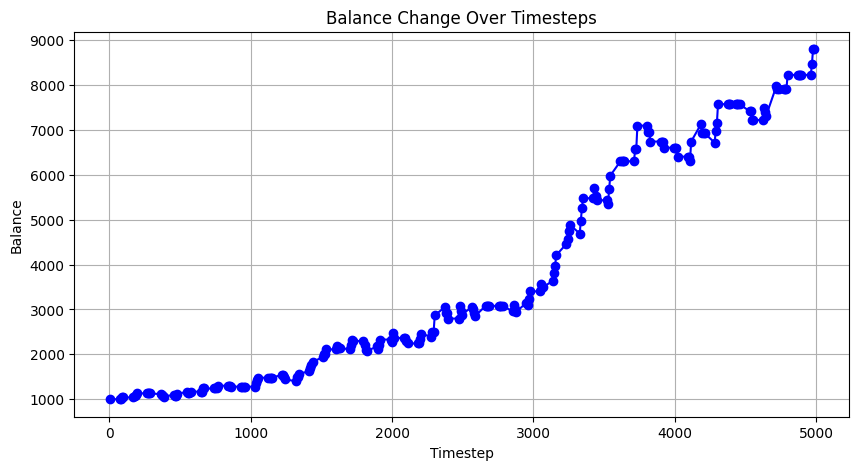

In [ ]:
import matplotlib.pyplot as plt

# Extract balance and corresponding index (timesteps)
last_balance = 1000
balances = []
indices = []

for trade in trade_details:
    if trade["enter_market"]:
        balances.append(trade["balance"])
        last_balance = balances[-1]
    else:
        balances.append(last_balance)
    
    indices.append(trade["index"])  # Store the timestep

# Plot the balance change with respect to timesteps
plt.figure(figsize=(10, 5))
plt.plot(indices, balances, marker='o', linestyle='-', color='b')
plt.title('Balance Change Over Timesteps')
plt.xlabel('Timestep')
plt.ylabel('Balance')
plt.grid(True)
plt.show()


CSV saved: trade_balances.csv
Fitted Exponential Equation: y = 1030.43 * exp(0.000443 * x)


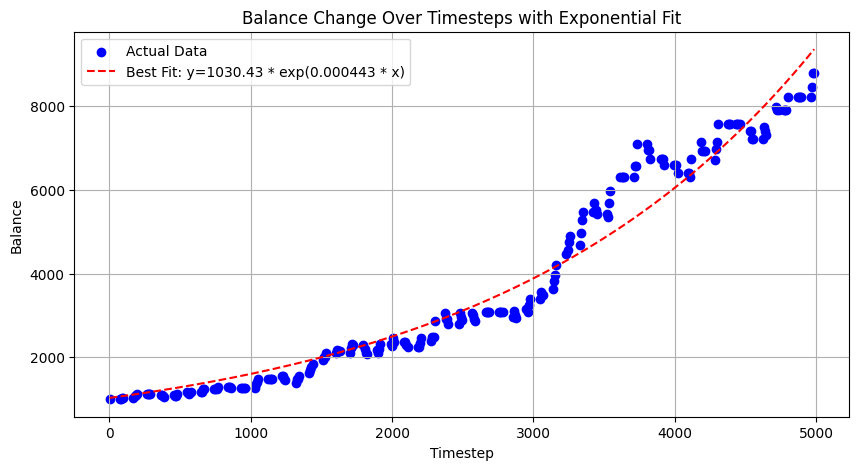

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract balance and corresponding index (timesteps)
last_balance = 1000
balances = []
indices = []

for trade in trade_details:
    if trade["enter_market"]:
        balances.append(trade["balance"])
        last_balance = balances[-1]
    else:
        balances.append(last_balance)
    
    indices.append(trade["index"])  # Store the timestep

# Save as CSV
df = pd.DataFrame({"Timestep": indices, "Balance": balances})
csv_filename = "trade_balances.csv"
df.to_csv(csv_filename, index=False)
print(f"CSV saved: {csv_filename}")

# Define an exponential function for fitting
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Convert to numpy arrays for fitting
x_data = np.array(indices, dtype=float)
y_data = np.array(balances, dtype=float)

# Fit the exponential model
params, covariance = curve_fit(exponential_func, x_data, y_data, p0=(1000, 0.0001))

# Extract the fitted parameters
a_fit, b_fit = params
print(f"Fitted Exponential Equation: y = {a_fit:.2f} * exp({b_fit:.6f} * x)")

# Generate fitted curve data
x_fit = np.linspace(min(x_data), max(x_data), 300)
y_fit = exponential_func(x_fit, *params)

# Plot the balance change and best fit line
plt.figure(figsize=(10, 5))
plt.scatter(x_data, y_data, color='blue', label='Actual Data')
plt.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Best Fit: y={a_fit:.2f} * exp({b_fit:.6f} * x)')
plt.title('Balance Change Over Timesteps with Exponential Fit')
plt.xlabel('Timestep')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)
plt.show()
